#### THIS PROGRAM LOADS UP THE H SURFACE DATA (Using Hasigma5.f) AND PLOTS IT.

In [1]:
# Libraries used and plot setup:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import scipy as sc
from scipy import stats
import os
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv # https://ipyvolume.readthedocs.io/en/latest/install.html
from ipywidgets import VBox
from matplotlib import cm
from matplotlib import ticker 

# Some general setup for plots:
#mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 17
mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

In [2]:
# IMPORTANT PARAMETER DEFINITIONS:

# Kp:K resonance?
Kp = 3
K  = 2
RESONANCIA = str(Kp) + '-' + str(K) # String "Kp-K"

# perturber eccentricity ep? 
ep = 0.01
ep_text = "{0:.1g}".format(ep) # .1g implies consider 1 significative digit for ep.
 
# DIRECTORIES:
# Common directory root (in Windows use inverted double slash "\\"; in Linux use single slash "/"):
COMUN = "/home/juan/Escritorio/TESIS/"

# H surface data directory:
dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma/COPLANAR/" + RESONANCIA + "/ep=" + ep_text + "/"
# dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma/COPLANAR/Aplicaciones/Marte/"+RESONANCIA+"/"
file_H = "HSUP_high_RHtol=0.00.dat" # filename

# Numerical integration directory:
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/GUIADO POR 3DH" + "/e2=" + ep_text + "/"
dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/MINIMO EW - INICIAL CORRIDO" + "/e2=" + ep_text + "/w=180/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/MINIMOS SEGUN MAPAS/R_sigma_w1" + "/e2=" + ep_text + "/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/LEY ESTRUCTURA" + "/e2=" + ep_text + "/short/"
# dir_evorb = COMUN + "PROGRAMAS/EVORB15/COPLANAR/Restricto/" + RESONANCIA + "/OTROS/1/"
datos_evorb = "datos.dat"
file_evorb = 'orbitasreo.sal'

# Graphics directory:
dir_graf = COMUN + "DOC/Restricto/" + RESONANCIA + "/ep=" + ep_text + "/"  

# SOME SETUP:
# If ANGLE = 0 => The angles: (0, 360). If ANGLE = 1 => The angles: (-180,180). 
ANGLE = 0
# Use theta instead of sigma? 
THETA = False
# Plot mindis surface?
MINDIS = True
# Filter according RHtol? (encounter if mindis<RHtol)
RHtol = 3
# Load numerical integration file? 
INTEGRACION = False
# Use numerical integration from REBOUND notebook?
COMPARAR = False
# Select the particles (used if INTEGRACION = True or COMPRAR = True):
#CASES = np.array([33, 35, 37])-9 # evorb format:  [33, 35, 37] - 9   
CASES = np.array([6, 12, 21])-2 # rebound format:  [6, 12, 21] - 2
CASES = np.array([6, 13, 10, 3])-2 # 

# Color asigned for each case in CASES
COLORS = ['yellow', 'limegreen', 'blue'] #['limegreen', 'cyan', 'red']
COLORS = ['yellow', 'blue', 'red', 'violet']  

# Save plots? (only normal plots, interactive ones are saved using the widget menu)
GUARDAR = False
# Image quality? (en ppp, 100 esta ok)
cal = 100
# Format? ('png', 'jpeg', 'eps', etc)
formato = 'jpeg'
# File names:
fileH_graf = "HSUP." + formato
fileMD_graf = "MDSUP." + formato


In [3]:
# EVORB15 NUMERICAL INTEGRATION IS PROCESSED:
if (INTEGRACION):

    # In Din is load the data
    Din = pd.read_csv(dir_evorb + file_evorb , delimiter=r"\s+")

    # This piece of code is to find 3 parameters from datos.dat (input file for numerical integration)
    string1 = 'TIEMPO MAXIMO DE LA SIMULACION'
    string2 = 'INTERVALO DE ESCRITURA'
    string3 = 'NUMERO DE PARTICULAS'

    # opening a text file
    file = open(dir_evorb + datos_evorb, "r", encoding = "ISO-8859-1")

    # setting flag to 0
    flag = 0

    # Loop through the file line by line
    for line in file:

        if (flag == 1):
            T_tot = int(float(line)) # Tiempo de integracion total
            flag = 0
        if (flag == 2):
            DT_esc = int(float(line)) # Intervalo de escritura
            flag = 0
        if (flag == 3):
            Npar = int(float(line)) # Nro de partículas
            flag = 0

        # checking string is present in line or not
        if string1 in line:
            flag = 1
        if string2 in line:
            flag = 2
        if string3 in line:
            flag = 3

    #print(T_tot, DT_esc, Npar)
    # closing datos.dat
    file.close()

    Npla = 1 # N° de planetas
    Nobj = Npla + Npar # N° de objetos
    
    # Number of points:
    Nt = int(T_tot/DT_esc) # Total integration time / Writing interval

    # The precision can be lowered to run the code faster:
    FIL = 10 # FIL is the number of points that are skipped. FIL = 1 does not skip any data.
    Din = Din[Din.index.map(lambda x: x%FIL==0)]  # BETTER WAY TO filter the data
    #Din = Din[Din['t'] % int(FIL*DT_esc) == 0]
    Nt = int(Nt/FIL)   

    # DEFINO LOS ÍNDICES DE LOS OBJETOS:
    obj = np.insert(np.arange(10, 10 + Npar), 0 , np.arange(1, 1 + Npla)) # 10 es el indice de la primer partícula
    # Inicializo matriz 3D con todos los objetos: 
    D = np.empty((Nobj, Nt+1, 8)) # 8 son las columnas que hay en archivo_evorb
    D[:] = np.NaN
    # Recorro los Nobj índices de objetos y filtro segun columna 'N' para asignar a la matriz 3D
    for i, j in zip(range(len(obj)), obj):
        # Esto es para considerar los casos donde la partícula es eyectada prematuramente
        N_vivo = np.count_nonzero((Din['N'].values == j)) 
        D[i, 0:N_vivo, :] =  Din[Din['N'].values == j]
    # Paso a dataframe el planeta:
    D_pla =  pd.DataFrame(D[0,:,:], columns = ['t','a','e','i','nodo','argper','anomed','N'])

    # CASE selects the particle:
    D_obj=[]
    for CASE in CASES:
        D_obj.append( pd.DataFrame(D[CASE,:,:], columns = ['t','a','e','i','nodo','argper','anomed','N']) )

    # Filtro NaNs:
    # D_pla = D_pla[~(np.isnan(D_obj['t'].values))]
    # D_obj = D_obj[~(np.isnan(D_obj['t'].values))] 

    # Planet elements:
    varpi_p = D_pla['nodo'].values + D_pla['argper'].values
    varpi_p = np.remainder(varpi_p, 360)
    lambda_p = varpi_p + D_pla['anomed'].values

    # Adjust angles:
    if (ANGLE == 1):
        varpi_p = np.where(varpi_p>180, varpi_p - 360, varpi_p) # To change domain from (0, 360) to (-180, 180)
        lambda_p = np.where(lambda_p>180, lambda_p - 360, lambda_p)

    # Number of cases
    Ncas = len(CASES)

    # Initialize numerical integration variables:
    # t = np.empty((Ncas, Nt+1)) 
    # a = np.empty((Ncas, Nt+1)) 
    e          = np.empty((Ncas, Nt+1))
    varpi      = np.empty((Ncas, Nt+1))
    lambda_    = np.empty((Ncas, Nt+1))
    sigma      = np.empty((Ncas, Nt+1))
    #theta      = np.empty((Ncas, Nt+1))
    DeltaVarpi = np.empty((Ncas, Nt+1))

    for i in range(Ncas):

    #     # OBTAIN TIME
    #     t[i] = D_obj[i]['t'].values
    #     #t_single = np.sort(list(set(t))) # Remove duplicated values and the sort them up.

    #     # TSPAN = Max time to show in the plots.
    #     TSPAN = max(t) # By default

        # INTEGRATION VARIABLES:
    #     a[i] = D_obj[i]['a'].values
        e[i] = D_obj[i]['e'].values

        # VARPIs & LAMBDAs:
        varpi[i] = D_obj[i]['nodo'].values + D_obj[i]['argper'].values
        varpi[i] = np.remainder(varpi[i], 360)
        lambda_[i] = varpi[i] + D_obj[i]['anomed'].values

        # SIGMA & THETA DEFINITIONS:
        if (THETA):
            sigma[i] = (K*lambda_[i] - Kp*lambda_p + (Kp-K)*varpi_p)
        else:
            sigma[i] = (K*lambda_[i] - Kp*lambda_p + (Kp-K)*varpi[i])
        sigma[i] = np.remainder(sigma[i], 360)
    #    theta[i] = (K*lambda_[i] - Kp*lambda_p + (Kp-K)*varpi_p)
    #    theta[i] = np.remainder(theta[i], 360)

        # Adjust angles:
        if (ANGLE == 1):  # To change domain from (0, 360) to (-180, 180)
            varpi[i] = np.where(varpi[i]>180, varpi[i] - 360, varpi[i])
            sigma[i] = np.where(sigma[i]>180, sigma[i] - 360, sigma[i]) 
    #        theta[i] = np.where(theta[i]>180, theta[i] - 360, theta[i])
            lambda_[i] = np.where(lambda_[i]>180, lambda_[i] - 360, lambda_[i])  

        # DEF. DELTA VARPI:    
        DeltaVarpi[i] = varpi[i] - varpi_p
        DeltaVarpi[i] = np.remainder(DeltaVarpi[i], 360)
        if (ANGLE == 1):  # To change domain from (0, 360) to (-180, 180)
            DeltaVarpi[i] = np.where(DeltaVarpi[i]>180, DeltaVarpi[i] - 360, DeltaVarpi[i])

    #     # VARIABLES h & k:
    #     h[i] = e[i]*np.sin(varpi[i]*pi/180)
    #     k[i] = e[i]*np.cos(varpi[i]*pi/180)

    #     old piece of code (to update in the future if necessary):
    #     # CÁLCULO DE ALGUNOS VALORES DE INTERÉS (a partir de la integración):
    #     # Promedios 
    #     e_mean = np.mean(e)
    #     # Calculo el promedio de los ángulos según https://en.wikipedia.org/wiki/Mean_of_circular_quantities
    #     varpi_mean = np.arctan2(np.mean(np.sin(varpi*pi/180)), np.mean(np.cos(varpi*pi/180)))*180/pi
    #     sigma_mean = np.arctan2(np.mean(np.sin(sigma*pi/180)), np.mean(np.cos(sigma*pi/180)))*180/pi
    #     # Paso estos promedios al intervalo (0, 360)
    #     varpi_mean = float(np.where(varpi_mean < 0, varpi_mean + 360, varpi_mean))
    #     sigma_mean = float(np.where(sigma_mean < 0, sigma_mean + 360, sigma_mean))

    #     # Valores iniciales:
    #     e_inic = e[0]
    #     varpi_inic = varpi[0]
    #     sigma_inic = sigma[0]    # Mantengo vapri_inic en (0,360)
    #     varpi_inic_360 = float(np.where(varpi_inic<0, varpi_inic + 360, varpi_inic)) 
    #     sigma_inic_360 = float(np.where(sigma_inic<0, sigma_inic + 360, sigma_inic))
    #     h_inic = h[0]
    #     k_inic = k[0]
    #     # Calculo M_inic por si hay que extender la integración:
    #     M_inic =  (sigma_inic - Kp*varpi_inic)/K
    #     M_inic = np.remainder(M_inic, 360)

In [4]:
# Filter Hamiltonian data?
FILTER = True

# Define box limits:
emin = 0.01
emax = 0.99
wmin = -180
wmax = -10
smin = -180
smax = -100

In [5]:
# LOAD HAMILTONIAN DATA:
Din_Hsup = pd.read_csv(dir_H + file_H, delimiter=r"\s+")
H = Din_Hsup['H'].values

# Remove outliers (https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python) 
z_scores = sc.stats.zscore(H)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
Din_Hsup = Din_Hsup[filtered_entries]      

if (MINDIS):    
    Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
    MD_sup = Din_Hsup['mindis'].values
    
# Obtain variables from dataframe:
E_sup = Din_Hsup['e_ast'].values
W_sup = Din_Hsup['w_ast'].values % 360
H_sup = Din_Hsup['H'].values
S_sup = Din_Hsup['sigma'].values % 360

res_angle = "σ"
if (THETA):
    S_sup = (S_sup - (Kp-K)*W_sup) % 360
    res_angle = "θ"
    
if (ANGLE == 1):
    W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
    S_sup = np.where(S_sup>180, S_sup - 360, S_sup)
    
    
# Filter data:    
if (FILTER):

    Din_Hsup = Din_Hsup[ ~(((E_sup>=emin)&(E_sup<=emax))&((W_sup>=wmin)&(W_sup<=wmax))&((S_sup>=smin)&(S_sup<=smax))) ]
    Din_Hsup.reset_index(inplace=True)
    
    if (MINDIS):    
        Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
        MD_sup = Din_Hsup['mindis'].values
    
    # Obtain variables again after filtering:
    E_sup = Din_Hsup['e_ast'].values
    W_sup = Din_Hsup['w_ast'].values % 360
    H_sup = Din_Hsup['H'].values
    S_sup = Din_Hsup['sigma'].values % 360

    if (THETA):
        S_sup = (S_sup - (Kp-K)*W_sup) % 360

    if (ANGLE == 1):
        W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
        S_sup = np.where(S_sup>180, S_sup - 360, S_sup)

In [6]:
# Creating a customized colormap to plot in grayscale the model and in colors the numerical integration
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

resol = 32 # Number of levels from 'binary' colormap
Ncm = 25 # 'binary' colormap is concatenated Ncm times 
          # So, the total levels are resol*Ncm

cmap_used = 'gray' # seismic, gray, binary, jet, hsv
top = cm.get_cmap(cmap_used + '_r', resol)
bottom = cm.get_cmap(cmap_used, resol)
newcolors = np.vstack((top(np.linspace(0, 1, resol)), bottom(np.linspace(0, 1, resol))))

for n in range(Ncm): 
    seg1 = cm.get_cmap(cmap_used + '_r', resol)
    seg2 = cm.get_cmap(cmap_used, resol)
    newcolors = np.vstack(( seg1(np.linspace(0, 1, resol)), seg2(np.linspace(0, 1, resol)), newcolors ))

newcm = ListedColormap(newcolors, name='Ngrayscale') # newcm is the new colormap used in the next cell


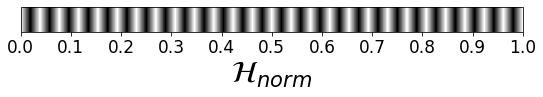

In [7]:
# INTERACTIVE PLOT OF THE 3D H SURFACE:

# Colors used:
#colormap = cm.gist_ncar
#colormap = cm.flag
colormap = newcm

# *** HAMILTONIAN: ***
# Colormap generation:
#H_map = np.log10(np.abs(H_sup))
H_map = (H_sup-H_sup.min())/(H_sup.max()-H_sup.min())
min_H = H_map.min()
max_H = H_map.max()
znorm = H_map - min_H
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

# ************************************ FIGURE ****************************************
ipv.style.use('seaborn-darkgrid')
fig = ipv.figure()

# * PLOT: *
ipv.scatter(E_sup, W_sup, S_sup, size=1.5, color = color, marker="sphere") # Model

if (INTEGRACION):     # Numerical integrations from EVORB15
    #COLORS = ['yellow', 'green', 'purple']
    for i in range(Ncas):                       
        ipv.scatter(e[i], DeltaVarpi[i], sigma[i], size=2.5, color = COLORS[i], marker="sphere")

if (COMPARAR):       # Numerical integrations from REBOUND
    %store -r ap 
    %store -r ep
    %store -r Ip
    %store -r Op
    %store -r wp
    %store -r Mp
    %store -r a
    %store -r e
    %store -r I
    %store -r O
    %store -r w
    %store -r M
    %store -r t
#     CASES = np.array([5, 12, 9, 2]) 
#     COLORS = ['yellow', 'blue', 'red', 'violet']
    ind = 0
    for j in CASES:    
        i = j# - 1
        deltaW = (w[i] - wp) % 360
        if (THETA):
            sigma = (K*( M[i]+w[i]+O[i] ) - Kp*( Mp+wp+Op)) % 360
        else:
            sigma = (K*( M[i]+w[i]+O[i] ) - Kp*( Mp+wp+Op) + (Kp-K)*w[i]) % 360
        if (ANGLE == 1):
            deltaW = np.where(deltaW>180, deltaW - 360, deltaW)
            sigma = np.where(sigma>180, sigma - 360, sigma)
        ipv.scatter(e[i], deltaW, sigma, size=2.5, color = COLORS[ind], marker="sphere")
        ind = ind + 1
    
# Single point:
#ipv.scatter(np.array([0.73]), np.array([180.0]), np.array([0.0]), size=2.5, color = 'orange', marker="sphere")

# Color bar
norma = mpl.colors.Normalize(vmin=min_H, vmax=max_H)
cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(), 
                  orientation = 'horizontal', shrink = 1.5)
cb.set_label(label=r'$\mathcal{H}_{norm}$', size = 30)
tick_locator = ticker.MaxNLocator(nbins=10)
cb.locator = tick_locator
cb.update_ticks()
plt.gca().set_visible(False)
    
# Box limits:8
ipv.xlim(0, 1)
if (ANGLE == 0):
    ipv.ylim(0, 360)
    ipv.zlim(0, 360)
else:         
    ipv.ylim(-180, 180)
    ipv.zlim(-180, 180)
# labels   
ipv.xyzlabel("e", "ϖ", res_angle)

#ipv.pylab.style.box_on()
#ipv.style.axes_off()#(which = 'x')

# # Save a movie or gif:
# def set_view(fig, framenr, fraction):
#     ipv.view(fraction*360, (fraction - 0.5) * 180, distance=2 + fraction*2)
#     #fig.angley = fraction*np.pi*2
# ipv.movie('prueba.gif', set_view, fps=5, frames=10)

ipv.show()

#  NOTE: Sometimes the interactive plot stop working. Try to re-run this cell. 
#         If doesn't work, reboot Jupyter Lab. If not, the pc.

Delta_min (in Rhill): 3.00061441
Delta_max (in Rhill): 19.5277005


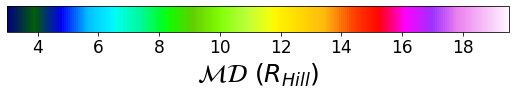

In [8]:
# INTERACTIVE PLOT OF THE 3D mindis SURFACE:
if (MINDIS):
    
    # Colors used:
    colormap2 = cm.gist_ncar
    #colormap2 = cm.flag

    # *** MINDIS: ***
    # Colormap generation:
    min_DIS =  MD_sup.min()
    max_DIS = MD_sup.max()
    znorm2 = MD_sup - min_DIS
    print('Delta_min (in Rhill):', min_DIS)
    print('Delta_max (in Rhill):', max_DIS)
    znorm2 /= znorm2.ptp()
    znorm2.min(), znorm2.max()
    color2 = colormap2(znorm2)    
    
    # ************************************ FIGURE ****************************************

    ipv.style.use('seaborn-darkgrid')
    fig2 = ipv.figure()

    # * PLOT: *
    ipv.scatter(E_sup, W_sup, S_sup, size=1.5, color = color2, marker="sphere")
   
    # Color bar
    norma2 = mpl.colors.Normalize(vmin=min_DIS, vmax=max_DIS)
    cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), orientation = 'horizontal', shrink = 1.5)
    cb.set_label(label=r'$\mathcal{MD}$ ($R_{Hill}$)', size = 25)
    tick_locator = ticker.MaxNLocator(nbins=10)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.gca().set_visible(False)


    # Box limits:
    ipv.xlim(0, 1)
    if (ANGLE == 0):
        ipv.ylim(0, 360)
        ipv.zlim(0, 360)
    else:         
        ipv.ylim(-180, 180)
        ipv.zlim(-180, 180)
    # labels   
    ipv.xyzlabel("e", "ϖ", res_angle)
    #ipv.pylab.style.box_on()
    #ipv.style.axes_off()#(which = 'x')

    ipv.show()
    
#  NOTE: Sometimes the interactive plot stop working. Try to re-run this cell. If doesn't work, reboot Jupyter Lab. If not, the pc.

THE NEXT CELLS ARE TO PLOT NON-INTERACTIVE SURFACE PLOTS:

In [9]:
# # Normal H surface plot:
# plt.style.use('seaborn-whitegrid')
# #plt.rcParams['axes.prop_cycle']

# fig3 = plt.figure(figsize=(15,10))
# ax = fig3.add_subplot(111, projection='3d')

# # Scatter plot:
# img1 = ax.scatter(E_sup, W_sup, S_sup, c=color)

# # Labels y ticks:
# ax.set(xlabel = '\n$e$', ylabel = '\n'+r'  $\varpi$ (°)')
# if (ANGLE == 0):
#     angles = np.arange(0, 360 + 90, 90)
#     ax.set(xlim = [0, 1], ylim = [0, 360], zlim = [0, 360], yticks = angles, zticks = angles)
# else:
#     angles = np.arange(-180, 180 + 90, 90)
#     ax.set(xlim = [0, 1], ylim = [-180, 180], zlim = [-180, 180], yticks = angles, zticks = angles)
# ax.zaxis.set_rotate_label(False) 
# ax.set_zlabel('          ' + res_angle + ' (°)     ', rotation=0)

# # # Color bar:
# # norma = mpl.colors.Normalize(vmin=min_H, vmax=max_H)
# # cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(), 
# #                    orientation = 'vertical', shrink=0.9, fraction=0.025, pad=0.1)
# # cb.ax.set_ylabel(r'$\mathcal{H}$', rotation=0, size=20, labelpad = 20) 
# # improvement to do: normalize colorbar...

# # View angle:
# ax.view_init(elev=35, azim=315)


# plt.show();

# # Save image
# if (GUARDAR):
#     if not os.path.exists(dir_graf):
#         os.makedirs(dir_graf)
#     fig3.savefig(dir_graf + fileH_graf, dpi = int(cal), format = formato, bbox_inches='tight');
#     print('Saved in: ', dir_graf + fileH_graf)

In [10]:
# # Normal MinDis surface plot:
# if (MINDIS):    
    
#     plt.style.use('seaborn-whitegrid')
#     fig4 = plt.figure(figsize=(15,10))
#     ax = fig4.add_subplot(111, projection='3d')

#     # Scatter plot:
#     img2 = ax.scatter(E_sup, W_sup, S_sup, c=color2)

#     # Labels y ticks:
#     ax.set(xlabel = '\n$e$', ylabel = '\n'+r'  $\varpi$ (°)')
#     if (ANGLE == 0):
#         ax.set(xlim = [0, 1], ylim = [0, 360], zlim = [0, 360], yticks = angles, zticks = angles)
#     else:         
#         ax.set(xlim = [0, 1], ylim = [-180, 180], zlim = [-180, 180], yticks = angles, zticks = angles)
#     ax.zaxis.set_rotate_label(False) 
#     ax.set_zlabel('          ' + res_angle + ' (°)     ', rotation=0)

#     # Color bar:
#     cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), 
#                        orientation = 'vertical', shrink=0.9, fraction=0.025, pad=0.1)
#     #ylabel = 'Mín. distance in Rhill'
#     ylabel = r'$\Delta$'
#     cb.ax.set_ylabel(ylabel, rotation=0, size=20, labelpad = 20)

#     # View angle:
#     ax.view_init(elev=35, azim=315)

#     plt.show();

#     # Save image
#     if (GUARDAR):
#         if not os.path.exists(dir_graf):
#             os.makedirs(dir_graf)
#         fig4.savefig(dir_graf + fileMD_graf, dpi = int(cal), format = formato, bbox_inches='tight');
#         print('Saved in: ', dir_graf + fileMD_graf)

In [11]:
%store -r e_c
%store -r dw_c
%store -r e
%store -r dw

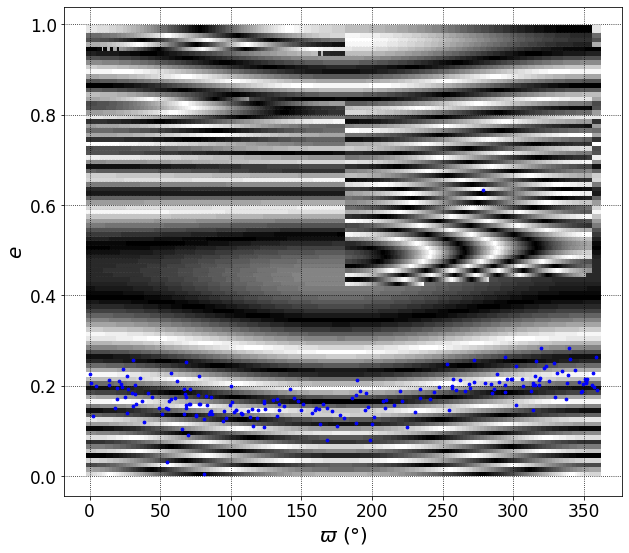

In [12]:
# PROJECTION OF H SURFACE + INTEGRATION
figp = plt.figure(figsize=(10,9))
axp = figp.add_subplot(111, xlabel = r'$\varpi$ (°)', ylabel = '$e$')

plt.scatter(W_sup, E_sup, c=H_sup, marker = 's', s = 50, cmap = newcm, zorder = 0)#, alpha = 0.3)
plt.scatter(dw_c, e_c, c = 'blue', s = 30, marker=".", zorder = 2)

if (INTEGRACION):  # Numerical integration (evorb15)
    #COLORS = ['yellow', 'green', 'purple']
    for i in range(Ncas):                                                                
        plt.scatter(DeltaVarpi[i], e[i], s=30, color = COLORS[i])

if (COMPARAR):   # Numerical integration (rebound)
    ind = 0   
    for j in CASES:    
        i = j #- 1
        deltaW = (w[i] - wp) % 360
        sigma = (K*( M[i]+w[i]+O[i] ) - Kp*( Mp+wp+Op) + (Kp-K)*w[i]) % 360
        if (ANGLE == 1):
            deltaW = np.where(deltaW>180, deltaW - 360, deltaW)
            sigma = np.where(sigma>180, sigma - 360, sigma)
        plt.scatter(deltaW, e[i], c = COLORS[ind], s = 30, marker=".", zorder = 2)
        ind = ind + 1
        
plt.grid(c='k', ls=':')
# If there are problems of hiding, try zorder parameter.

#GUARDAR = True
# Save image
if (GUARDAR):
    if not os.path.exists(dir_graf):
        os.makedirs(dir_graf)
    file_graf = 'Hproj_ew.' + formato    
    figp.savefig(dir_graf + file_graf, dpi = int(cal), format = formato, bbox_inches='tight');
    print('Saved in: ', dir_graf + file_graf)

In [13]:
# print(a)
a_mean = np.mean(a, axis = 1)
print(a_mean)
print(len(a_mean))

a_norm = a[0][0]
print(a_norm)

a_err = (( a_mean - a_norm )/a_norm)*100

print(a_err)
print(e[8][0])

a_amp = np.max(a, axis = 1) - np.min(a, axis = 1)
print(a_amp*100)

NameError: name 'a' is not defined

In [ ]:
fig = plt.figure(figsize=(10,9))
plt.scatter(t, a[8])
plt.scatter(0, a_norm, c='r')
plt.xlim([-100,1e4])

In [ ]:
fig = plt.figure(figsize=(9,9))
plt.scatter(w[8],e[8])

In [ ]:
# PROGRAM END